```
This file is part of sscx-connectome-manipulations.

SPDX-License-Identifier: Apache-2.0
Copyright (c) 2024 Blue Brain Project/EPFL
```

# Figures related to SSCx connectome manipulations

## Part II: Functional figures

We demonstrate the applicability of our [Connectome-Manipulator](https://github.com/BlueBrain/connectome-manipulator) framework by manipulating the connectome of a detailed model of the rat somatosensory cortex (SSCx) and quantifying functional changes through network simulations.

ℹ️ This notebook reproduces the functional figures from [Pokorny et al. (2024)](https://doi.org/10.1101/2024.05.24.593860)

<u>Requirements</u>:
- [BlueETL](https://github.com/BlueBrain/blueetl) (Python venv)
- [CortexETL](https://github.com/BlueBrain/cortexetl) (Cloned repo)
- Simulation/calibration analysis results (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to recompute)
- Output from missing synapse estimation (available on [Zenodo](https://zenodo.org/); see instructions in `README.md` on how to recompute)

In [1]:
import os
import tqdm
import yaml

import blueetl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.patches import Rectangle
from scipy.stats import linregress, ranksums


In [2]:
# Set and create output figures folder
figs_path = './figs_funct'
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

### Interneurons rewired

Results figures related to a simulation experiment with spontaneous activity, during which a 1s current injection is appplied to the rewired VIP+ (SBC/BTC) interneurons.

- Spontaneous activity
- 1s current injection in SBC/BTC interneurons

ℹ️ Set results path below pointing to location of analysis results

In [64]:
# Results path
res_path = "/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/interneuron_rewiring/analysis"
sim_spec = "Ca1p05_Pfr0p3_Rou0p4"

In [12]:
# Check simulation condition
sim_cond = "curr_inj_amp_nA"
sims_orig = pd.read_parquet(os.path.join(res_path, "orig", sim_spec, "spikes", "repo", "simulations.parquet"))
sims_manip = pd.read_parquet(os.path.join(res_path, "manip", sim_spec, "spikes", "repo", "simulations.parquet"))

cond_val = sims_orig[sim_cond].values
assert np.array_equal(cond_val, sims_manip[sim_cond].values), "ERROR: Condition value mismatch!"
print(f"{sim_cond}: {', '.join([str(_v) for _v in cond_val])}")

curr_inj_amp_nA: 0.05, 0.1, 0.15, 0.2, 0.25


In [13]:
# Load rate histograms
hist_df_orig = pd.read_parquet(os.path.join(res_path, "orig", sim_spec, "spikes", "features", "histograms.parquet"))
hist_df_manip = pd.read_parquet(os.path.join(res_path, "manip", sim_spec, "spikes", "features", "histograms.parquet"))

# Available histograms
print(f'Bin size: {hist_df_orig["bin_size"].unique()}')
print(f'Smoothing type: {hist_df_orig["smoothing_type"].unique()}')
print(f'Kernel SD: {hist_df_orig["kernel_sd"].unique()}')

Bin size: [  1.   3.   5.  10. 100.]
Smoothing type: ['None' 'Gaussian']
Kernel SD: [-1.  1.  3.  5. 10.]


In [58]:
# Check time windows
wnd_df_orig = pd.read_parquet(os.path.join(res_path, "orig", sim_spec, "spikes", "repo", "windows.parquet"))
wnd_df_manip = pd.read_parquet(os.path.join(res_path, "manip", sim_spec, "spikes", "repo", "windows.parquet"))
wnd_names = wnd_df_orig["window"].unique()
assert np.array_equal(wnd_names, wnd_df_manip["window"].unique())
windows = {_wnd: wnd_df_orig.etl.first(window=_wnd)[["t_start", "t_stop"]].to_numpy().astype(float) for _wnd in wnd_names}
print("Windows:")
for _wnd in wnd_names:
    assert np.array_equal(wnd_df_manip.etl.first(window=_wnd)[["t_start", "t_stop"]].to_numpy().astype(float), windows[_wnd])
    print(f"  {_wnd}: {windows[_wnd]}s")

Windows:
  w1_spont: [2000. 5000.]s
  w2_inj: [5000. 6000.]s
  w3_rec: [6000. 7000.]s
  w4_spont: [ 7000. 10000.]s
  w_all: [ 2000. 10000.]s


In [59]:
# Run significance test between orig/manip
def get_norm_signal(hist_df, ref_window="w1_spont", data_window="w_all"):
    """Normalize data window signal w.r.t. ref window."""
    h_ref = hist_df.etl.q(window=ref_window).values.mean()
    h_data = hist_df.etl.q(window=data_window).values
    # return h_data - h_ref  # Offset-corrected
    return (h_data - h_ref) / h_ref  # Normalized

def sliding_ranksums(s1, s2, N_wnd=1000):
    """Sliding window Wilcoxon rank-sum statistic for two samples.
       s1, s2 ... Signals to test
       N_wnd  ... Sliding window length in samples (window centered)"""
    assert len(s1) == len(s2), "ERROR: Signal length mismatch!"
    p_val = np.full_like(s1, np.nan)
    il = np.round(N_wnd / 2).astype(int)  # Left index offset
    ir = N_wnd - il  # Right index offset
    for i in tqdm.tqdm(range(len(s1))):
        w1 = s1[np.maximum(i - il, 0) : np.minimum(i + ir, len(s1))]
        w2 = s2[np.maximum(i - il, 0) : np.minimum(i + ir, len(s1))]
        p_val[i] = ranksums(w1, w2).pvalue
    return p_val

cond_sel = 0.25  # nA
cond_idx = np.where(cond_val == cond_sel)[0]

window_name = "w_all"
window = windows[window_name]

bin_size = 10 # (ms)
smoothing_type = "Gaussian"
kernel_sd = 1.0

p_wnd = 20  # Sliding window length
class_sel = ["ALL_EXC", "Stim_INH", "NoStim_INH"]
p_val = {}
for nrn_class in class_sel:
    r1 = hist_df_orig.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values
    r2 = hist_df_manip.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"].values
#     r1 = get_norm_signal(hist_df_orig.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"], data_window=window_name)
#     r2 = get_norm_signal(hist_df_manip.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"], data_window=window_name)
    p_val[nrn_class] = sliding_ranksums(r1, r2, N_wnd=p_wnd)


100%|██████████| 800/800 [00:00<00:00, 1584.51it/s]


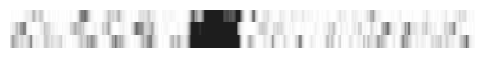

ALL_EXC: MIN -0.000, MAX 7.201
Stim_INH: MIN -0.000, MAX 7.201
NoStim_INH: MIN -0.000, MAX 7.201


In [60]:
plt.figure(figsize=(6, 0.5))
plt.imshow(np.vstack([-np.log10(p_val[_class]) for _class in class_sel]), interpolation="nearest", cmap="Greys", vmin=0, vmax=8)
plt.axis("tight")
plt.axis("off")
plt.show()

for _class in class_sel:
    print(f"{_class}: MIN {np.min(-np.log10(p_val[_class])):.3f}, MAX {np.max(-np.log10(p_val[_class])):.3f}")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/pokorny/2241337/ipykernel_265411/2259542121.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


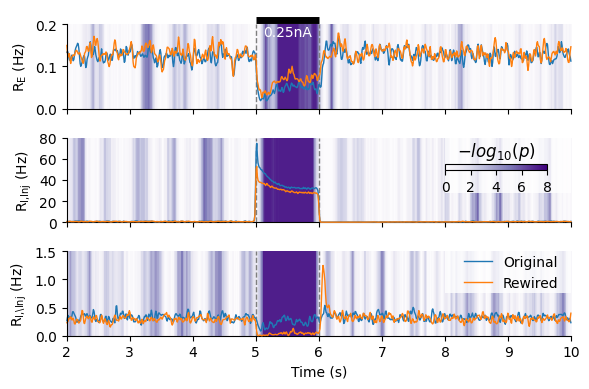

In [62]:
# Plot rates over time, incl.significance
color_orig = "tab:blue"
color_manip = "tab:orange"
p_max = 8
lbl_map = {"ALL_EXC": "R$_{\\mathrm{E}}$", "Stim_INH": "R$_{\\mathrm{I{,}Inj}}$", "NoStim_INH": "R$_{\\mathrm{I{,}\\backslash Inj}}$"}
r_max = {"ALL_EXC": 0.2, "Stim_INH": 80, "NoStim_INH": 1.5}  # Ca1p05_Pfr0p3_Rou0p4

inj_window_name = "w2_inj"
inj_window = windows[inj_window_name]

plt.figure(figsize=(6, 4))
for idx, nrn_class in enumerate(class_sel):
    plt.subplot(len(class_sel), 1, idx + 1)
    h_data_orig = hist_df_orig.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"]
    h_data_manip = hist_df_manip.etl.q(simulation_id=cond_idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"]

    assert h_data_orig.etl.labels_of("bin").equals(h_data_manip.etl.labels_of("bin"))
    t = h_data_orig.etl.labels_of("bin") * bin_size + window[0] + 0.5 * bin_size

    h_data_orig = h_data_orig.values / (bin_size * 1e-3)
    h_data_manip = h_data_manip.values / (bin_size * 1e-3)

    plt.plot(t * 1e-3, h_data_orig, color=color_orig, lw=1, clip_on=False, label="Original")
    plt.plot(t * 1e-3, h_data_manip, color=color_manip, lw=1, clip_on=False, label="Rewired")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_zorder(0)
    plt.xlim(window * 1e-3)
    # plt.ylim(plt.ylim())
    plt.ylim((0, r_max[nrn_class]))
    plt.imshow([-np.log10(p_val[nrn_class])], interpolation="nearest", cmap="Purples", zorder=0, aspect="auto", extent=[*(window * 1e-3), *plt.ylim()], vmin=0, vmax=p_max)
    plt.vlines(inj_window * 1e-3, *plt.ylim(), color="tab:gray", ls="--", lw=1, zorder=0)
    plt.ylabel(f"{lbl_map[nrn_class]} (Hz)")
    if idx == 0:
        plt.plot(inj_window * 1e-3, [1.05 * np.max(plt.ylim())] * 2, "k", lw=5, clip_on=False, solid_capstyle="butt", zorder=0)
        plt.text(np.mean(inj_window * 1e-3), np.max(plt.ylim()), f"\n{cond_sel}nA", ha="center", va="center", color="w")
    if idx == len(class_sel) - 1:
        y = 0.5 * np.max(plt.ylim())
        plt.gca().add_patch(Rectangle([8, y], 2, np.max(plt.ylim()) - y, fill=True, facecolor="w", alpha=0.8))
        plt.legend(loc="upper right", frameon=False, bbox_to_anchor=(1.0, 1.1))
        plt.xlabel("Time (s)")
    else:
        plt.gca().set_xticklabels([])
    if idx == 1:
        plt.yticks(np.arange(0, r_max[nrn_class] + 0.1, 20))
        y = 0.35 * np.max(plt.ylim())
        plt.gca().add_patch(Rectangle([8, y], 2, np.max(plt.ylim()) - y, fill=True, facecolor="w", alpha=0.8))
        plt.colorbar(orientation="horizontal", ticks=np.arange(0, p_max + 0.1, 2), cax=plt.axes([0.75, 0.56, 0.17, 0.015], title="$-log_{10}(p)$"))
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f"{sim_spec}_current_inj_rates_{cond_sel}nA.png"), dpi=600)
plt.savefig(os.path.join(figs_path, f"{sim_spec}_current_inj_rates_{cond_sel}nA.svg"), dpi=600)
plt.show()

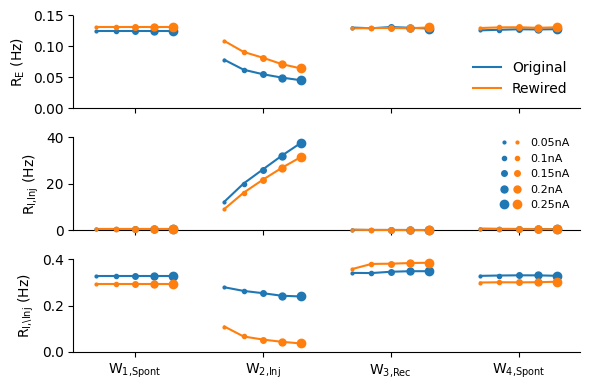

In [63]:
# Plot extracted firing rates
ftr_df_orig = pd.read_parquet(os.path.join(res_path, "orig", sim_spec, "spikes", "features", "by_neuron_class.parquet"))
ftr_df_manip = pd.read_parquet(os.path.join(res_path, "manip", sim_spec, "spikes", "features", "by_neuron_class.parquet"))

wlist =["w1_spont", "w2_inj", "w3_rec", "w4_spont"]
wnd_map = {"w1_spont": "W$_{\\mathrm{1{,}Spont}}$", "w2_inj": "W$_{\\mathrm{2{,}Inj}}$", "w3_rec": "W$_{\\mathrm{3{,}Rec}}$", "w4_spont": "W$_{\\mathrm{4{,}Spont}}$"}
r_max = {"ALL_EXC": 0.15, "Stim_INH": 40, "NoStim_INH": 0.4}  # Ca1p05_Pfr0p3_Rou0p4
# r_max = {"ALL_EXC": 0.25, "Stim_INH": 40, "NoStim_INH": 1.0}  # Ca1p05_Pfr0p6_Rou0p2, Ca1p1_Pfr0p6_Rou0p2
plt.figure(figsize=(6, 4))
for idx, nrn_class in enumerate(class_sel):
    plt.subplot(len(class_sel), 1, idx + 1)
    for widx, wname in enumerate(wlist):
        r_data_orig = ftr_df_orig.etl.q(neuron_class=nrn_class, window=wname)["mean_of_mean_firing_rates_per_second"]
        r_data_manip = ftr_df_manip.etl.q(neuron_class=nrn_class, window=wname)["mean_of_mean_firing_rates_per_second"]
        sim_ids = r_data_orig.etl.labels_of("simulation_id")
        assert np.array_equal(sim_ids, r_data_manip.etl.labels_of("simulation_id"))
        x = 0.6 * (sim_ids - np.mean(sim_ids)) / np.max(sim_ids)
        plt.plot(widx + x, r_data_orig, "-", color=color_orig, clip_on=False, label=None if widx else "Original")
        plt.plot(widx + x, r_data_manip, "-", color=color_manip, clip_on=False, label=None if widx else "Rewired")
        h_lgd2a = []
        h_lgd2b = []
        for s in sim_ids:
            h_a = plt.plot(widx + x[s], r_data_orig.iloc[s], "o", ms=s + 2, color=color_orig, clip_on=False)
            h_b = plt.plot(widx + x[s], r_data_manip.iloc[s], "o", ms=s + 2, color=color_manip, clip_on=False)
            h_lgd2a.append(h_a[0])
            h_lgd2b.append(h_b[0])
    plt.ylim((0, r_max[nrn_class]))
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_zorder(0)
    plt.xticks(range(len(wlist)), [wnd_map[_w] for _w in wlist])
    # plt.xlabel("Time windows")
    plt.ylabel(f"{lbl_map[nrn_class]} (Hz)")
    if idx == 0:
        plt.legend(frameon=False, loc="lower right")
    if idx == 1:
        lgd2a = plt.legend(h_lgd2a, ["" for _v in cond_val], frameon=False, loc="upper right", fontsize=8, bbox_to_anchor=(0.91, 1.1))
        lgd2b = plt.legend(h_lgd2b, [f"{_v}nA" for _v in cond_val], frameon=False, loc="upper right", fontsize=8, bbox_to_anchor=(1.0, 1.1), handletextpad=0.2)
        plt.gca().add_artist(lgd2a)
    if idx < len(class_sel) - 1:
        plt.gca().set_xticklabels([])
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f"{sim_spec}_current_inj_avg_rates.png"), dpi=600)
plt.savefig(os.path.join(figs_path, f"{sim_spec}_current_inj_avg_rates.svg"), dpi=600)
plt.show()

### Simplified connectome models

Results figures related to a recalibration procedure in order to match the spontaneous activity of the original and the five rewired circuits with simplified connectomes with _in vivo_ references.

- Spontaneous activity
- Re-calibration technique from (Isbister et al. 2023)
- Five iterations of re-calibration
- Comparison with missing synapses

ℹ️ Set paths accordingly:
- Config paths pointing to folder with config files from this repo
- Analysis path pointing to the results of the calibration analysis
- Calibration paths pointing to folder with .parquet files from calibration
- Missing synapses path pointing to results folder with missing synapse estimation
- Path to clones CortexETL repository

<u>Note</u>: Order 0 in file names denotes original (baseline) circuit

In [125]:
config_path = '../simplified_connectomes/configs'
res_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/analysis'
calib_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/calibration'
msyn_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/Zenodo/SSCx-connectome-manipulation-data/simplified_connectomes/missing_synapses'
cetl_path = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/cortex_etl'

ITER_NAMES = {_k: _v for _k, _v in enumerate(['first', 'second', 'third', 'fourth', 'fifth'])}

In [4]:
def upper(txt, first_n=None):
    if first_n is None:
        return txt.upper()
    else:
        return txt[:first_n].upper() + txt[first_n:]

def nrn_lbl(nclass):
    if isinstance(nclass, list):
        is_list = True
    else:
        is_list = False
        nclass = [nclass]
    out = []
    for _cl in nclass:
        l, c = _cl.split('_')
        out.append(''.join([l, c[0]]))
    if is_list:
        return out
    else:
        return out[0]

In [5]:
# Load .parquet files from re-calibration
order_list = [0, 1, 2, 3, 4, 5]  # 0...orig
desired_connected_proportion_of_invivo_frs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_iter = 5  # 0..first, 1..second, ...

calib_dfs = {}
for _pfr in desired_connected_proportion_of_invivo_frs:
    calib_dfs[_pfr] = []
    neuron_classes = None
    for iter_idx in range(num_iter):

        config_files = [f'connectome_rewiring_calibration_{_ord}-{iter_idx}.yaml' for _ord in order_list]
        calib_files = [f'order{_ord}_connection_data_from_{ITER_NAMES[iter_idx]}_iteration.parquet' for _ord in order_list]

        dfs_ord = []
        for _cfg, _cal in zip(config_files, calib_files):
            with open(os.path.join(config_path, _cfg), 'r') as f:
                cfg_dict = yaml.safe_load(f)
            vivo_frs = cfg_dict['analysis']['hex0_spikes']['custom']['vivo_frs']  # Load in-vivo reference firing rates from config

            df = pd.read_parquet(os.path.join(calib_path, _cal))
            df = df.loc[df['desired_connected_proportion_of_invivo_frs'] == _pfr]
            df['vivo_frs'] = [vivo_frs[_cl] for _cl in df['neuron_class']]  # Add in-vivo firing rates to data frame

            if neuron_classes is None:
                neuron_classes = df['neuron_class'].tolist()
            else:
                assert np.array_equal(neuron_classes, df['neuron_class'].tolist()), 'ERROR: Neuron class mismatch!'

            dfs_ord.append(df)
        calib_dfs[_pfr].append(dfs_ord)

In [6]:
ORDER_COLORS = ['black', 'tab:purple', 'tab:blue', 'tab:green', 'tab:orange', 'tab:red']
ORDER_NAMES = [f'Order {_ord}' if _ord else 'Original' for _ord in order_list]
ITER_LABELS = {_k: _v for _k, _v in enumerate(['1st', '2nd', '3rd', '4th', '5th'])}

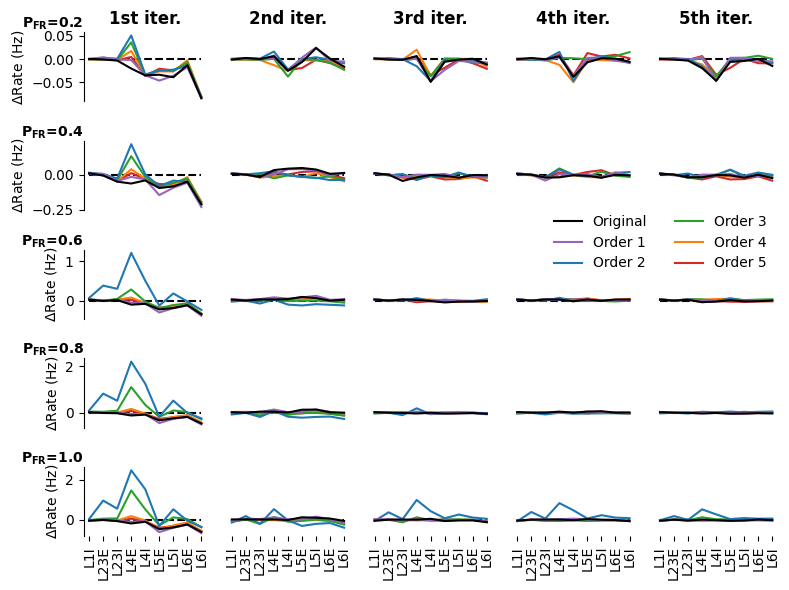

In [7]:
# Plot firing rate difference to target firing rate over iterations => Supplementary figure
pfr_list = [0.2, 0.4, 0.6, 0.8, 1.0]
plt.figure(figsize=(8, 6))
for pfr_idx, pfr_sel in enumerate(pfr_list):
    y_lim = None
    for iter_idx in range(num_iter):
        plt.subplot(len(pfr_list), num_iter, pfr_idx * num_iter + iter_idx + 1)
        for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
            mfr = _df['mean_of_mean_firing_rates_per_second'].values  # Mean FR
            tfr = _df['desired_connected_fr'].values  # Target FR
            plt.plot(range(len(neuron_classes)), mfr - tfr, '-', color=ORDER_COLORS[_ord], label=None if pfr_idx + iter_idx else ORDER_NAMES[_ord], zorder=-_ord)
        plt.plot(range(len(neuron_classes)), np.zeros(len(neuron_classes)), 'k--', zorder=-100)
        plt.xticks(range(len(neuron_classes)), nrn_lbl(neuron_classes), rotation=90)
        if iter_idx == 0:
            plt.ylabel('$\Delta$Rate (Hz)')
        else:
            # plt.gca().set_yticklabels([])
            plt.yticks([])
            plt.gca().spines['left'].set_visible(False)
        if pfr_idx == 0:
            plt.title(f'{upper(ITER_LABELS[iter_idx], 1)} iter.', fontweight='bold')
        if pfr_idx < len(pfr_list) - 1:
            # plt.gca().set_xticklabels([])
            plt.xticks([])
            plt.gca().spines['bottom'].set_visible(False)
        if y_lim is None:
            y_lim = plt.ylim()
        else:
            plt.ylim(y_lim)
        if iter_idx == 0:
            plt.text(np.min(plt.xlim()), np.max(plt.ylim()), '$\\mathbf{P_{FR}}$' + f'={pfr_sel}', ha='right', va='bottom', fontweight='bold')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
plt.figlegend(frameon=False, ncols=2, loc='lower right', bbox_to_anchor=(0.98, 0.52))
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'simpl_conn_calibration.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calibration.svg'), dpi=600)
plt.show()

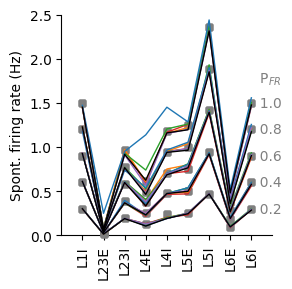

In [8]:
# Plot firing rates after calibration (i.e., after 5th iteration)
pfr_list = [0.2, 0.4, 0.6, 0.8, 1.0]
iter_idx = num_iter - 1
plt.figure(figsize=(3, 3))
for pfr_idx, pfr_sel in enumerate(pfr_list):
    for _ord, _df in zip(order_list, calib_dfs[pfr_sel][iter_idx]):
        mfr = _df['mean_of_mean_firing_rates_per_second'].values  # Mean FR
        tfr = _df['desired_connected_fr'].values  # Target FR
        plt.plot(range(len(neuron_classes)), tfr, 's', color='tab:gray', ms=4, zorder=-100, label=None, clip_on=False)  # label=None if pfr_idx + _ord else 'Reference'
        plt.plot(range(len(neuron_classes)), mfr, '-', color=ORDER_COLORS[_ord], lw=1, label=None if pfr_idx else ORDER_NAMES[_ord], zorder=-_ord, clip_on=False)
    plt.text(len(neuron_classes) - 1, tfr[-1], f'  {pfr_sel}', ha='left', va='center', color='tab:gray')
plt.text(len(neuron_classes) - 1, tfr[-1], '  P$_{FR}$\n\n\n', ha='left', va='center', color='tab:gray')
plt.xticks(range(len(neuron_classes)), nrn_lbl(neuron_classes), rotation=90)
plt.xlim((-1, len(neuron_classes)))
plt.ylabel('Spont. firing rate (Hz)')
plt.ylim((0, 2.5))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_zorder(-200)
plt.gca().xaxis.set_zorder(-200)
# plt.legend(frameon=False, ncols=2, loc='upper left', bbox_to_anchor=(0.04, 1.0))
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_rates.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_rates.svg'), dpi=600)
plt.show()

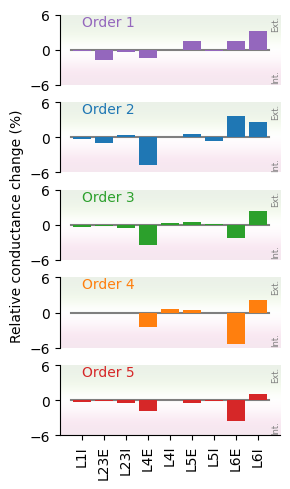

In [9]:
# Plot relative conductances after calibration (i.e., after 5th iteration)
# => Averaged over all P_FRs

iter_idx = num_iter - 1  # Last iteration
ref_idx = 0  # Original

ref_df = [calib_dfs[_pfr][iter_idx][ref_idx] for _pfr in desired_connected_proportion_of_invivo_frs]
ref_cond = 1e6 * np.mean([_df['true_mean_conductance'].values for _df in ref_df], 0)  # Average over all P_FRs

ylim = 6  # +/- ylim
plt.figure(figsize=(3, 5))
for _ord in order_list[1:]:
    plt.subplot(len(order_list) - 1, 1, _ord)
    ord_df = [calib_dfs[_pfr][iter_idx][_ord] for _pfr in desired_connected_proportion_of_invivo_frs]
    ord_cond = 1e6 * np.mean([_df['true_mean_conductance'].values for _df in ord_df], 0)  # Average over all P_FRs
    # plt.plot(range(len(neuron_classes)), ord_cond - ref_cond, '-', color=ORDER_COLORS[_ord], label=ORDER_NAMES[_ord], zorder=-_ord, clip_on=False)
    plt.plot([-0.5, len(neuron_classes) - 0.5], np.zeros(2), '-', color='tab:gray', zorder=-100, clip_on=False)
    plt.bar(range(len(neuron_classes)), 100 * (ord_cond - ref_cond) / ref_cond, color=ORDER_COLORS[_ord], label=ORDER_NAMES[_ord], zorder=-_ord, clip_on=False)
    plt.xticks(range(len(neuron_classes)))
    if _ord != order_list[-1]:
        plt.xticks([])
        plt.gca().spines['bottom'].set_visible(False)
    else:
        plt.gca().set_xticklabels(nrn_lbl(neuron_classes), rotation=90)
    if _ord == 3:
        plt.ylabel(f'Relative conductance change (%)')
    plt.xlim((-1, len(neuron_classes)))
    plt.ylim((-ylim, ylim))
    plt.imshow([[1], [0]], cmap='PiYG', interpolation='bicubic', extent=[*plt.xlim(), *plt.ylim()], alpha=0.1, zorder=-1000)
    plt.text(np.max(plt.xlim()), 0.99 * np.max(plt.ylim()), 'Ext.', rotation=90, ha='right', va='top', color='tab:grey', fontsize=6, zorder=-300)
    plt.text(np.max(plt.xlim()), 0.95 * np.min(plt.ylim()), 'Int.', rotation=90, ha='right', va='bottom', color='tab:grey', fontsize=6, zorder=-300)
    plt.axis('tight')
    plt.yticks([-np.floor(ylim).astype(int), 0, np.floor(ylim).astype(int)])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_zorder(-200)
    plt.gca().xaxis.set_zorder(-200)
    plt.text(0, np.max(plt.ylim()), ORDER_NAMES[_ord], ha='left', va='top', color=ORDER_COLORS[_ord])
# plt.legend(frameon=False, ncols=2, loc='upper left', bbox_to_anchor=(0.0, 1.0))
plt.tight_layout()
plt.subplots_adjust(hspace=0.25)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_rel_cond.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_rel_cond.svg'), dpi=600)
plt.show()

In [10]:
# Load missing synapses (pre-computed in missing_synapses.ipynb)
df_file = os.path.join(msyn_path, 'missing_counts.h5')

df_missing_counts_mean = pd.read_hdf(df_file, 'missing_counts_mean')
df_missing_counts_std = pd.read_hdf(df_file, 'missing_counts_std')

ORDER_KEYS = ['Orig', 'Order-1', 'Order-2', 'Order-3', 'Order-4', 'Order-5']

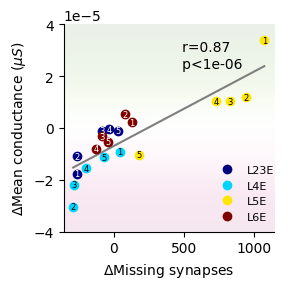

In [11]:
# Missing synapses within cell group, rel. to Original
iter_idx = num_iter - 1  # Last iteration
exc_classes = list(filter(lambda c: c[-3:] == 'EXC', neuron_classes))
class_colors = plt.cm.jet(np.linspace(0, 1, len(exc_classes)))
txt_colors = ['w', 'k', 'k', 'w']
ref_idx = 0  # Original
x_vals = []
y_vals = []
plt.figure(figsize=(3, 3))
for nidx, nrn_class in enumerate(exc_classes):
    ref_df = [calib_dfs[_pfr][iter_idx][ref_idx].etl.q(neuron_class=nrn_class) for _pfr in desired_connected_proportion_of_invivo_frs]
    ref_cond = np.mean([_df['true_mean_conductance'].values for _df in ref_df], 0)[0]  # Average over all P_FRs
    ref_msyns = df_missing_counts_mean.loc[ORDER_KEYS[ref_idx], nrn_lbl([nrn_class])].etl.one()
    has_lbl = False
    for _ord in order_list:
        if _ord == ref_idx:
            continue
        ord_df = [calib_dfs[_pfr][iter_idx][_ord].etl.q(neuron_class=nrn_class) for _pfr in desired_connected_proportion_of_invivo_frs]
        ord_cond = np.mean([_df['true_mean_conductance'].values for _df in ord_df], 0)[0]  # Average over all P_FRs
        msyns = df_missing_counts_mean.loc[ORDER_KEYS[_ord], nrn_lbl([nrn_class])].etl.one()
        x = msyns - ref_msyns
        y = ord_cond - ref_cond
        x_vals.append(x)
        y_vals.append(y)
        plt.plot(x, y, 'o', color=class_colors[nidx], label=None if has_lbl else nrn_lbl(nrn_class), zorder=-_ord, clip_on=False)
        has_lbl = True
        if _ord > 0:
            plt.text(msyns - ref_msyns, ord_cond - ref_cond, str(_ord), color=txt_colors[nidx], fontsize=6, ha='center', va='center')
slope, intercept, r, p, _ = linregress(x_vals, y_vals)
plt.plot(sorted(x_vals), [slope * _x + intercept for _x in sorted(x_vals)], '-', color='tab:gray', zorder=-100)
y_lim = 4e-5
plt.ylim([-y_lim, y_lim])
plt.imshow([[1], [0]], cmap='PiYG', interpolation='bicubic', extent=[*plt.xlim(), *plt.ylim()], alpha=0.1, zorder=-1000)
plt.axis('auto')
alpha = 1e-6
assert p < alpha
plt.text(np.mean(plt.xlim()), np.max(plt.ylim()), f'\n   r={r:.2f}\n   p<{alpha}', color='k', ha='left', va='top')
plt.xlabel('$\Delta$Missing synapses')
plt.ylabel('$\Delta$Mean conductance ($\mu S$)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, loc='lower right', bbox_to_anchor=(1.05, 0.0), fontsize=8)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_cond_vs_msyns.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_cond_vs_msyns.svg'), dpi=600)
plt.show()

In [126]:
# Need to import a function from CortexETL repo
import sys
sys.path.append(cetl_path)
from cortex_etl import dist_target_FRs

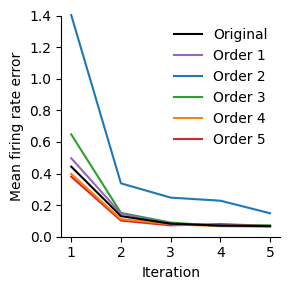

In [124]:
# Euclidean distance to target firing rate (Mean over PFRs)
ca = 1.05
depol_stdev_mean_ratio = 0.4
pfr_list = desired_connected_proportion_of_invivo_frs
vivo_frs = calib_dfs[1.0][0][0].set_index("neuron_class")["vivo_frs"]
nrn_classes = vivo_frs.keys()

plt.figure(figsize=(3, 3))
for _ord in order_list:
    xvals = []
    yvals = []
    ystds = []
    for _it in range(num_iter):
        euc_dist_to_scaled_in_vivo_FRs = [dist_target_FRs(calib_dfs[_pfr][_it][_ord], vivo_frs, _pfr, nrn_classes) for _pfr in desired_connected_proportion_of_invivo_frs]
        xvals.append(_it + 1)
        yvals.append(np.mean(euc_dist_to_scaled_in_vivo_FRs))
        ystds.append(np.std(euc_dist_to_scaled_in_vivo_FRs))
    plt.plot(xvals, yvals, '-', color=ORDER_COLORS[_ord], label=ORDER_NAMES[_ord], zorder=-_ord, clip_on=False)
    # plt.errorbar(x=xvals, y=yvals, yerr=ystds, fmt='-', color=ORDER_COLORS[_ord], label=ORDER_NAMES[_ord], zorder=-_ord, clip_on=False)
plt.xticks(xvals)
plt.ylim([0.0, 1.4])
plt.xlabel('Iteration')
plt.ylabel('Mean firing rate error')  # = Eucl. distance to target firing rate
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_mean_error.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_calib_mean_error.svg'), dpi=600)
plt.show()


In [130]:
# Check available histograms
hist_df = pd.read_parquet(os.path.join(res_path, "SSCx-HexO1-Release-TC__Hex0Calib0", "hex0_spikes", "features", "histograms.parquet"))

print(f'Bin size: {hist_df["bin_size"].unique()}')
print(f'Smoothing type: {hist_df["smoothing_type"].unique()}')
print(f'Kernel SD: {hist_df["kernel_sd"].unique()}')

Bin size: [1. 3. 5.]
Smoothing type: ['None' 'Gaussian']
Kernel SD: [-1.  1.  3.]


In [137]:
# Select window
window_name = "conn_spont"
wnd_df = pd.read_parquet(os.path.join(res_path, "SSCx-HexO1-Release-TC__Hex0Calib0", "hex0_spikes", "repo", "windows.parquet"))
window = wnd_df.etl.first(window=window_name)[["t_start", "t_stop"]].to_numpy()
print(f'Window "{window_name}": {list(window)}ms')

Window "conn_spont": [1500.0, 6500.0]ms


In [138]:
# Select histogram settings
bin_size = 5.0  # (ms)
smoothing_type = "Gaussian"
kernel_sd = 1.0

class_sel = ["L1_INH", "L23_EXC", "L23_INH", "L4_EXC", "L4_INH", "L5_EXC", "L5_INH", "L6_EXC", "L6_INH"]

P_FR: 1.0
Taget FRs: [1.5   0.07  0.961 0.619 1.184 1.252 2.357 0.47  1.5  ]


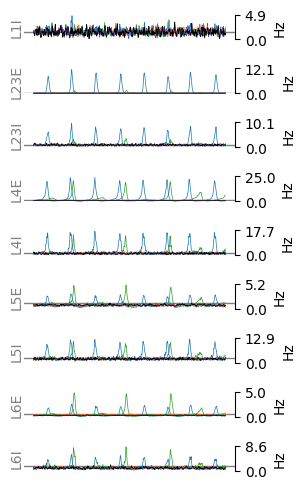

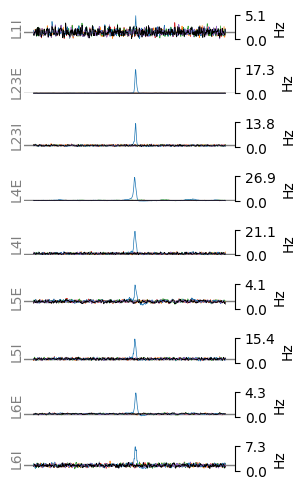

In [141]:
# Plot layer-wise instantaneous firing rates
pfr_sel = 1.0  # 0.8  # <== SELECT HERE WHAT P_FR TO PLOT
pfr_idx = np.where(np.array(desired_connected_proportion_of_invivo_frs) == pfr_sel)[0]

_df = calib_dfs[pfr_sel][0][0]
assert np.array_equal(_df['neuron_class'], class_sel), 'ERROR: Class mismatch!'
tfr = _df['desired_connected_fr'].values  # Target FR
print(f'P_FR: {pfr_sel}')
print(f'Taget FRs: {tfr}')

for _iter in [0, 4]:  # First/last iteration
    plt.figure(figsize=[3, 5])
    for _idx, nrn_class in enumerate(class_sel):
        plt.subplot(len(class_sel), 1, _idx + 1)
        r_max = 0
        for _ord in order_list:
            ord_str = "" if _ord == 0 else f"__ConnRewireOrder{_ord}Hex0EE"
            hist_df = pd.read_parquet(os.path.join(res_path, f"SSCx-HexO1-Release-TC{ord_str}__Hex0Calib{_iter}", "hex0_spikes", "features", "histograms.parquet"))
            h_data = hist_df.etl.q(simulation_id=pfr_idx, neuron_class=nrn_class, window=window_name, bin_size=bin_size, smoothing_type=smoothing_type, kernel_sd=kernel_sd)["hist"]
            t = h_data.etl.labels_of("bin") * bin_size + window[0] + 0.5 * bin_size
            h_data = h_data.values / (bin_size * 1e-3)
            plt.plot(t, h_data, color=ORDER_COLORS[_ord], lw=0.5, clip_on=False, zorder=-_ord)
            r_max = np.maximum(r_max, np.max(h_data))
#         print(f'{nrn_class}: Max. rate {r_max:.2f}Hz')
        plt.ylim([0.0, np.max(plt.ylim())])
        y_tck = [0.0, np.max(plt.ylim())]
        plt.yticks(y_tck, [f'{_y:.1f}' if _y == 0 or _y > 0.1 else f'{_y:.2f}' for _y in y_tck])
        plt.xlim(plt.xlim())
        plt.xticks([])
        plt.plot(plt.xlim(), [tfr[_idx]] * 2, color='tab:grey', lw=1, zorder=-100)
#         plt.axis('off')
        plt.gca().yaxis.set_label_position('right')
        plt.gca().yaxis.tick_right()
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.ylabel('Hz')
        plt.text(np.min(plt.xlim()), np.mean(plt.ylim()), nrn_lbl(nrn_class), color='tab:grey', rotation=90, ha='right', va='center')
    plt.tight_layout()
    plt.subplots_adjust(right=0.8)
    plt.savefig(os.path.join(figs_path, f'simpl_conn_rate_signals_iter{_iter}_Pfr{str(pfr_sel).replace(".", "p")}.png'), dpi=600)
    plt.savefig(os.path.join(figs_path, f'simpl_conn_rate_signals_iter{_iter}_Pfr{str(pfr_sel).replace(".", "p")}.svg'), dpi=600)
    plt.show()

In [142]:
# Compute E/I correlation
corr_window = "conn_spont"
corr_bin_size = 5.0
corr_smoothing_type = 'Gaussian'
corr_kernel_sd = 1.0
corr_layers = ["L23", "L4", "L5", "L6"]

cal_iter = 4

pfr_sel = desired_connected_proportion_of_invivo_frs
pfr_idx = [np.where(np.array(desired_connected_proportion_of_invivo_frs) == _pfr)[0] for _pfr in pfr_sel]
ei_corr_pfr = []
print(f'P_FR:', end=' ')
for _idx, _pfr in enumerate(pfr_idx):
    print(f'{pfr_sel[_idx]}', end=' ')
    ei_corr_rvalues = {}
    for _ord in order_list:
        ord_str = "" if _ord == 0 else f"__ConnRewireOrder{_ord}Hex0EE"
        hist_df = pd.read_parquet(os.path.join(res_path, f"SSCx-HexO1-Release-TC{ord_str}__Hex0Calib{cal_iter}", "hex0_spikes", "features", "histograms.parquet"))
        rvalues = []
        for lay in corr_layers:
            exc_data = hist_df.etl.q(simulation_id=_pfr, neuron_class=f"{lay}_EXC", window=corr_window, bin_size=corr_bin_size, smoothing_type=corr_smoothing_type, kernel_sd=corr_kernel_sd)["hist"].values
            inh_data = hist_df.etl.q(simulation_id=_pfr, neuron_class=f"{lay}_INH", window=corr_window, bin_size=corr_bin_size, smoothing_type=corr_smoothing_type, kernel_sd=corr_kernel_sd)["hist"].values
            rvalues.append(linregress(exc_data, inh_data).rvalue)
        ei_corr_rvalues[_ord] = rvalues
    ei_corr_pfr.append(ei_corr_rvalues)

P_FR: 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 

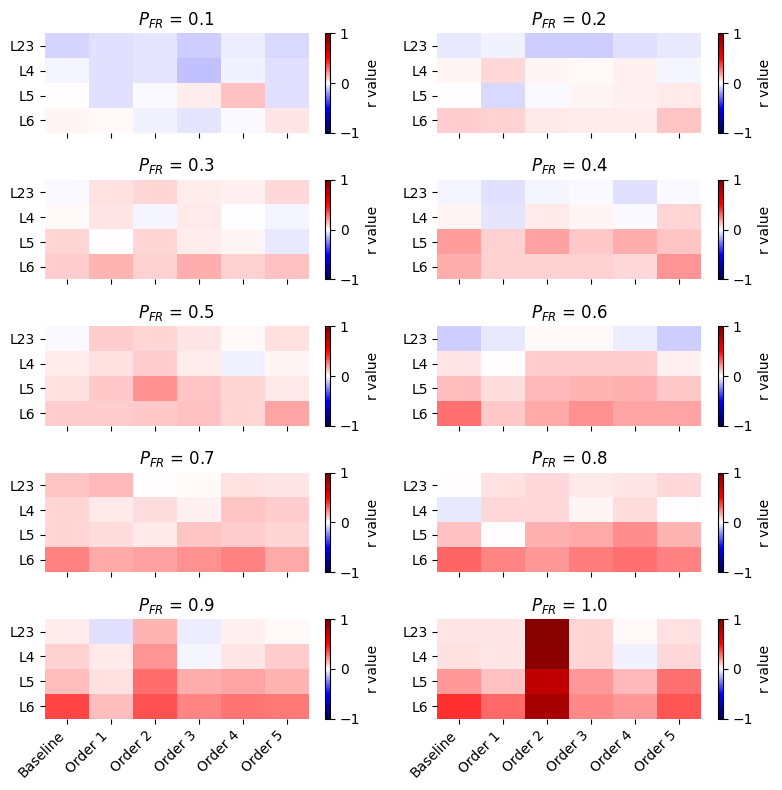

In [143]:
# Plot E/I correlation
corr_max = 1.0
corr_min = -1.0

plt.figure(figsize=(8, 8))
for _idx, ei_corr_rvalues in enumerate(ei_corr_pfr):
    plt.subplot(5, 2, _idx + 1)
    ei_corr_df = pd.DataFrame(ei_corr_rvalues, index=corr_layers)
    plt.imshow(ei_corr_df, vmin=corr_min, vmax=corr_max, cmap='seismic')
    plt.axis('tight')
    plt.colorbar(label='r value')
    plt.xticks(order_list, ['Baseline'] + [f'Order {_ord}' for _ord in order_list[1:]], rotation=45, ha='right')
    plt.yticks(range(len(corr_layers)), corr_layers)
    if _idx < len(ei_corr_pfr) - 2:
        plt.gca().set_xticklabels([])
    plt.title('$P_{FR}$ = ' + f'{pfr_sel[_idx]}')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join(figs_path, f'simpl_conn_ei_corr_iter{cal_iter}.png'), dpi=600)
plt.savefig(os.path.join(figs_path, f'simpl_conn_ei_corr_iter{cal_iter}.svg'), dpi=600)
plt.show()